In [185]:
import random
import time
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
def hyper_params_check(item_dict, bin_size, generations, pop_size, random_init, 
                       lower_gene_mutation_threshold, upper_gene_mutation_threshold,
                       lower_individual_mutation_threshold, upper_individual_mutation_threshold,
                       elites_num):
    if bin_size > len(item_dict):
        raise('Bin size must be lesser than the total number of items in the dataset')
    if bin_size < 0:
        raise('Bin size must be a positive integer')
    if type(bin_size) != int:
        raise('Bin size must be an integer')
    if bin_size < min(item_dict.values()):
        raise('Bin size must be able to accommodate for the smallest item in the dataset')
    
    if generations <= 0:
        raise('Number of generation must be a positive integer')
    if type(generations) != int:
        raise('Number of generations must be an integer')
        
    if pop_size <= 0:
        raise('Population size must be a positive integer')
    if type(pop_size) != int:
        raise('Population size must be an integer')
    
    if type(random_init) != bool:
        raise('Random init must be a bool type')
    
    if lower_gene_mutation_threshold < 0 or upper_gene_mutation_threshold < 0:
        raise('Gene mutation threshold must be between 0 and 1')
    if lower_gene_mutation_threshold > 1 or upper_gene_mutation_threshold > 1:
        raise('Gene mutation threshold must be between 0 and 1')
    if type(lower_gene_mutation_threshold) != float or type(upper_gene_mutation_threshold) != float:
        raise('Gene mutation threshold must be a float value between 0 and 1')
    
    if lower_individual_mutation_threshold < 0 or upper_individual_mutation_threshold < 0:
        raise('Gene mutation threshold must be between 0 and 1')
    if lower_individual_mutation_threshold > 1 or upper_individual_mutation_threshold > 1:
        raise('Gene mutation threshold must be between 0 and 1')
    if type(lower_individual_mutation_threshold) != float or type(upper_individual_mutation_threshold) != float:
        raise('Gene mutation threshold must be a float value between 0 and 1')
    
    if elites_num < 0 or elites_num > 1:
        raise('Proportion of elites individual must be between 0 and 1')
    if type(elites_num) != float:
        raise('Proportion of elites individual must be a float value')

In [142]:
def verify_num_item(solution, expected_item_num):
    """
    Verify the number of items in the solution dictionary.

    Parameters:
        solution (dict): A dictionary where keys represent categories and values
                        are lists of items in each category.
        expected_item_num (int): The expected total number of items.

    Returns:
        tuple: A tuple containing a flag indicating whether items are missing
               and the actual number of items found.
    """
    
    items = []
    missing_item_flag = False

    # Iterate through all items in the solution dictionary 
    for k,v in solution.items():
        for item in v:
            items.append(item)

    # Check if the number of items matches the expected count
    if len(items) != expected_item_num:
        missing_item_flag = True

    return missing_item_flag, len(items)

In [139]:
def shuffle_item_dict(data):
    """
    Shuffle the items in a dictionary.

    Parameters:
        data (dict): A dictionary to be shuffled.

    Returns:
        dict: A new dictionary with items shuffled.
    """
    
    keys = list(data.keys())
    
    np.random.shuffle(keys)
    
    data = {key : data[key] for key in keys}
    
    return data

In [140]:
def get_data(to_export_data, generation, avg_fitness, min_bin_number, highest_fitness):
    """
    Update data dictionary with information for the current generation.

    Parameters:
        to_export_data (dict): A dictionary containing data to be exported.
        generation (int): The current generation number.
        avg_fitness (float): The average fitness of the population.
        min_bin_number (int): The minimum bin number.
        highest_fitness (float): The highest fitness in the population.

    Returns:
        dict: The updated data dictionary.
    """
    
    to_export_data['Generation'].append(generation)
    to_export_data['AvgPopulationFitness'].append(avg_fitness)
    to_export_data['HighestPopulationFitness'].append(highest_fitness)
    to_export_data['MinimumBin'].append(min_bin_number)

    return to_export_data

In [141]:
def calculate_bin_weight(data, bins_collection, bin_no):
    """
    Calculate te total weight of items in a specified bin.

    Parameters:
    - data (dict): Dictionary containing the item no. and weights.
    - bins (dict): A dictionary representing a configuration, where keys are bin no. and values are lists of items in each bin.
    - bin_no (int): The index of the bin for which the total weight needs to be calculated.

    Returns:
    float: The total weight of items in the specified bin, rounded to one decimal place.
    """
    return round(sum([data[key] for key in bins_collection[bin_no]]),1)

In [88]:
def get_min_bin_number(population):
    """
    Get the individual with the minimum number of bins in the population.

    Parameters:
        population (list): A list of individuals, where each individual is represented as a list.

    Returns:
        tuple: A tuple containing the index and the number of bins for the individual with the minimum bins.
    """
    # Create a dictionary to store individual indices and their corresponding bin counts
    population_bins_dict = dict({})
    population_bins_dict = dict({})

    # Iterate through the population to count the number of bins for each individual
    for individual in range(len(population)):
        population_bins_dict.update({individual: len(population[individual])})
    
    individual = list(population_bins_dict.keys())
    bin_no = list(population_bins_dict.values())
    
    zipped_individual_bin_no = zip(individual, bin_no)
    unzipped_individual_bin_no = list(zipped_individual_bin_no)
    
    # Find the index of the individual with the minimum number of bins
    min_bin_index = bin_no.index(min(bin_no))
    min_bin = unzipped_individual_bin_no[min_bin_index]
    
    return min_bin

In [89]:
def initialise_candidate_FFH(data, bin_size):
    """
    Generate an initial solution using the random fitting approach.

    Parameters:
    - data (dict): Dictionary containing the item no. and weights.
    - bin_size (int): Maximum capacity of each bin.

    Returns:
    dict: A dictionary representing the initial configuration, where keys are bin no. and values are lists of items in each bin.
    """
    bin_no = 1
    init_bins = {bin_no: []}  # Opening the first bin

    # Shuffling the item_dict
    data = shuffle_item_dict(data=data)
    
    # Iterate through all the unique items
    for item_no, item_weight in data.items():
        # Retrieving the item no.
        current_item_no = item_no

        # Retrie the item weight
        current_weight = item_weight
        
        total_weight = 0

        # Iterate through existing bins
        for bin in init_bins:
            
            # Calculating the total weight of the randomly selected bin
            bin_total_weight = calculate_bin_weight(data, init_bins, bin)
            
            # Add the weight of the current unique item to the weight of the randomly selected bin
            total_weight = round((bin_total_weight + current_weight), 1)
            
            # Check if there is available space within the randomly selected bin
            if total_weight <= bin_size:
                
                # Adding the item to the bin
                init_bins[bin].append(current_item_no)
                break

        # Opening a new bin if the old bins are full
        if total_weight > bin_size:
            bin_no += 1
            init_bins.update({bin_no: [current_item_no]})
                
    return init_bins

In [92]:
def initialise_candidate_rand(data, bin_size):
    """
    Generate an initial solution using the random fitting approach.

    Parameters:
    - data (dict): Dictionary containing the item no. and weights.
    - bin_size (int): Maximum capacity of each bin.

    Returns:
    dict: A dictionary representing the initial configuration, where keys are bin no. and values are lists of items in each bin.
    """
    bin_no = 1
    init_bins = {bin_no: []}  # Opening the first bin

    # Shuffling the item_dict
    data = shuffle_item_dict(data=data)
    
    # Iterate through all the unique items
    for item_no, item_weight in item_dict.items():
        # Retrieving the item no.
        current_item_no = item_no
        
        # Retrie the item weight
        current_weight = item_weight
        
        total_weight = 0

        # Iterate through existing bins
        for _ in init_bins:
            # Randomly select an existing bin
            random_bin = np.random.choice(list(init_bins.keys()))
            
            # Calculating the total weight of the randomly selected bin
            random_bin_total_weight = calculate_bin_weight(data, init_bins, random_bin)
            
            # Add the weight of the current unique item to the weight of the randomly selected bin
            total_weight = round((random_bin_total_weight + current_weight), 1)
            
            # Check if there is available space within the randomly selected bin
            if total_weight <= bin_size:
                
                # Adding the item to the bin
                init_bins[random_bin].append(current_item_no)
                break

            # Opening a new bin if the old bins are full
            if total_weight > bin_size:
                bin_no += 1
                init_bins.update({bin_no: [current_item_no]})
                break
                
    return init_bins

In [145]:
def fitness(data, candidate_solution, bin_size = 100):
    """
    Calculate the fitness score for a candidate solution.

    Parameters:
        data (list): List of item weights.
        candidate_solution (list): Candidate solution represented as a list of bins.
        bin_size (int): Size of each bin.

    Returns:
        float: Fitness score for the candidate solution.
    """
    score = 0
    # Iterate through each bin in the candidate solution
    for bin_no in candidate_solution:
        # Calculate the fitness contribution for the current bin
        score_i = ((calculate_bin_weight(data, candidate_solution, bin_no) / bin_size)**2) / len(candidate_solution)

        # Sum the fitness
        score += score_i
        
    return round(score,3)

In [146]:
def avg_population_fitness(data, population, bin_size = 100):
    """
    Calculate the average fitness of a population.

    Parameters:
    - data (list): The input data.
    - population (list): List of candidate solutions.
    - bin_size (int, optional): Size of the bin for fitness calculation. Default is 100.

    Returns:
    - float: The average fitness of the population.
    """
    return round(sum([fitness(data=data, candidate_solution=candidate, bin_size=bin_size) for candidate in population])/len(population),3)

In [147]:
def get_repeated_items(crossover_section):
    """
    Get a sorted list of items from a dictionary of bins and items.

    Parameters:
    - crossover_section (dict): A dictionary representing bins and their associated items.

    Returns:
    - list: A sorted list of items from the crossover section.
    """    
    to_remove_items = []

    for bin,items in crossover_section.items():
        
        # Iterate through items in each bin and add them to the list
        for item in items:
            to_remove_items.append(item)
    
    # Sort the list of items
    to_remove_items.sort()

    return to_remove_items

In [148]:
def init_population(data = item_dict, pop_size = 100, bin_size = 100, random_init = False):
    """
    Initialize a population of candidates.

    Parameters:
    - data (dict, optional): The data dictionary. Defaults to item_dict.
    - pop_size (int, optional): The size of the population. Defaults to 100.
    - bin_size (int, optional): The bin size. Defaults to 100.
    - random_init (bool, optional): If True, initialize candidates randomly; 
      otherwise, use First-Fit Heuristic Approach. Defaults to False.

    Returns:
    - list: A list of initialized candidates for the population.
    """    
    if random_init is False:
        # Initialize candidates using the  First-Fit Heuristic Approach
        pop = [initialise_candidate_FFH(data, bin_size) for _ in range(pop_size)]
    else:
        # Initialize candidates randomly
        pop = [initialise_candidate_rand(data, bin_size) for _ in range(pop_size)]

    return pop

In [149]:
def selection(data, population, selection_size=50, bin_size= 100):
    """
    Perform Roulette Wheel Selection method.

    Parameters:
    - data (list): The input data.
    - population (list): List of candidate solutions.
    - selection_size (int, optional): Number of candidates to select. Defaults to 50.
    - bin_size (int, optional): Size of the bin for fitness calculation. Defaults to 100.

    Returns:
    - list: List of selected parents.
    """
    candidate_fitness_dict = dict({})

    # Calculate fitness for each candidate and store in a dictionary
    for candidate in range(len(population)):
        candidate_fitness = fitness(data=data, candidate_solution=population[candidate], bin_size=bin_size)
        candidate_fitness_dict[candidate] = candidate_fitness

    candidate_fitness_keys = candidate_fitness_dict.keys()
    candidate_fitness_values = candidate_fitness_dict.values()

    zipped_candidate_fitness_kv = zip(candidate_fitness_keys,candidate_fitness_values)
    candidate_fitness_list = list(zipped_candidate_fitness_kv)

    # Calculate the sum of fitness values
    fitness_sum = np.sum(list(candidate_fitness_dict.values()))

    # Spin the roulette wheel for parents selection
    selected_candidate_list = np.random.choice(
        a=[i for i in range(len(candidate_fitness_list))], 
        p=[fitness/fitness_sum for fitness in candidate_fitness_values], 
        replace=False, 
        size=selection_size)
    
    # Extract selected parents based on indices
    parents = [candidate_fitness_list[selected_candidate] for selected_candidate in selected_candidate_list]
    return parents

In [150]:
def mutation(data, individual, gene_mutation_rate = 0.3, bin_size = 100):
    """
    Perform mutation on an individual candidate.

    Parameters:
    - data (dict): The input data.
    - individual (dict): The candidate solution.
    - gene_mutation_rate (float, optional): Probability of mutating a gene. Defaults to 0.3.
    - bin_size (int, optional): Size of the bin for fitness calculation. Defaults to 100.

    Returns:
    - dict: Mutated candidate solution.
    """
    mu_individual = deepcopy(individual)

    bin_no = len(mu_individual)
    for gene in list(mu_individual):
    
        if round(np.random.uniform(),3) < gene_mutation_rate:

            #Eliminating a random gene
            item_list = sorted(mu_individual.pop(gene), reverse = True)
            
            for item in item_list:
                # Retrieve the item no.
                current_item_no = item
        
                # Retrieve the item weight
                current_weight = data[item]
                
                total_weight = 0
        
                # Iterate through existing bins
                for gene in mu_individual:              
                    # Calculate the total weight of the randomly selected bin
                    bin_total_weight = calculate_bin_weight(data, mu_individual, gene)
                    
                    # Add the weight of the current unique item to the weight of the randomly selected bin
                    total_weight = round((bin_total_weight + current_weight), 1)
                    
                    # Check if there is available space within the randomly selected bin
                    if total_weight <= bin_size:
                        
                        # Adding the item to the bin
                        mu_individual[gene].append(current_item_no)
                        break
        
                # Opening a new bin if the old bins are full
                if total_weight > bin_size:
                    bin_no += len(mu_individual)+1
                    mu_individual.update({bin_no: [current_item_no]})
        else:
            continue
    
        #Removing any empty bins
        mu_individual = {bin: item for bin,item in mu_individual.items() if item}

    # Renaming the bins correctly
    new_keys = list(range(1,len(mu_individual)+1))
    for key,new_key in zip(sorted(mu_individual.keys()), new_keys):
        mu_individual[new_key] = mu_individual.pop(key)

    return mu_individual

In [151]:
def inject(parent, crossover_section,to_remove_item):
    """
    Perform injection of items from the crossover section into the parent.

    Parameters:
    - parent (dict): The parent solution.
    - crossover_section (dict): The crossover section containing items to inject.
    - to_remove_item (list): List of items to remove from the parent.

    Returns:
    - dict: The child solution after injection.
    """ 
    for item in to_remove_item:
    
        #Finding the bin no in which the item belong in
        bin_no = [k for k, v in parent.items() if item in v][0]
        parent[bin_no].remove(item)
    
    #Injection
    last_bin = len(parent)
    for bin,item  in crossover_section.items():
        parent[last_bin+1] = item
        last_bin+=1
    
    #Removing any empty bins
    parent = {bin: item for bin,item in parent.items() if item}
    
    #Renaming the bins correctly
    new_keys = list(range(1,len(parent)+1))
    for key,new_key in zip(sorted(parent.keys()), new_keys):
        parent[new_key] = parent.pop(key)

    child = deepcopy(parent)
    
    return child

In [152]:
def crossover(parent_1, parent_2):
    """
    Perform crossover between two parents.

    Parameters:
    - parent_1 (dict): The first parent.
    - parent_2 (dict): The second parent.

    Returns:
    - tuple: Two children resulting from crossover.
    """  
    # Determine the minimum length between parent solutions
    if len(parent_1) < len(parent_2):
        min_length = len(parent_1)
    else:
        min_length = len(parent_2)

    # Select two crossover points
    crossover_points = sorted(np.random.choice(a=[num for num in range(1,min_length)], replace=False, size=2))
    crossover_point_1, crossover_point_2 = crossover_points[0],crossover_points[1]
    crossover_section_1, crossover_section_2 = dict({}), dict({})

    # Create crossover sections for both parents
    for i in range(crossover_point_1,crossover_point_2+1):
        crossover_section_1[i] = deepcopy(parent_1[i])
        crossover_section_2[i] = deepcopy(parent_2[i])

    # Identify repeated items to be removed from each parent
    to_remove_item_1 = get_repeated_items(crossover_section_1)
    to_remove_item_2 = get_repeated_items(crossover_section_2)

    # Create children by injecting crossover sections into the opposite parents
    child_1 = deepcopy(inject(parent=parent_1, crossover_section=crossover_section_2, to_remove_item=to_remove_item_2))
    child_2 = deepcopy(inject(parent=parent_2, crossover_section=crossover_section_1, to_remove_item=to_remove_item_1))

    return child_1, child_2

In [153]:
def select_crossover_section(min_length, max_length, crossover_point_1, crossover_point_2):
    """
    Select a crossover section between two points within a specified range.

    Parameters:
    - min_length (int): The minimum length of the range.
    - max_length (int): The maximum length of the range.
    - crossover_point_1 (int): The first crossover point.
    - crossover_point_2 (int): The second crossover point.

    Returns:
    - tuple: Updated crossover points representing the selected section.
    """
    random_num = np.random.choice(a=[num for num in range(min_length, max_length)], size=1)[0]

     # Determine the selected crossover section based on the random number
    if random_num < crossover_point_1:
        crossover_point_1, crossover_point_2 = min_length, crossover_point_1
        return crossover_point_1, crossover_point_2
    elif random_num > crossover_point_2:
        crossover_point_1, crossover_point_2 = crossover_point_2, max_length
        return crossover_point_1, crossover_point_2
    else:
        return crossover_point_1, crossover_point_2

In [154]:
def crossover_v2(parent_1, parent_2):
    """
    Perform crossover between two parents.

    Parameters:
    - parent_1 (dict): The first parent.
    - parent_2 (dict): The second parent.

    Returns:
    - tuple: Two children resulting from crossover.
    """
    # Determine the lengths of parent solutions
    if len(parent_1) > len(parent_2):
        max_length = len(parent_1)
        min_length = len(parent_2)
    else:
        max_length = len(parent_2)
        min_length = len(parent_1)
        
    crossover_point_1 = np.random.choice(a=[num for num in range(1,min_length)], size=1)[0]
    crossover_point_2 = np.random.choice(a=[num for num in range(1,max_length)], size=1)[0]
    crossover_section_1, crossover_section_2 = dict({}), dict({})

    # Crossover section for parent 1
    if len(parent_1) < crossover_point_2:
        crossover_point_2 = len(parent_1)

    # Randomly select a crossover section from parent 1
    new_crossover_point_1, new_crossover_point_2 = select_crossover_section(min_length=1, max_length=len(parent_1), 
                                                                    crossover_point_1=crossover_point_1, 
                                                                    crossover_point_2=crossover_point_2)
    # Extract the crossover section from parent 2
    for i in range(crossover_point_1, crossover_point_2 + 1):
        crossover_section_1[i] = deepcopy(parent_1[i])

    # Crossover section for parent 2
    if len(parent_2) < crossover_point_2:
        crossover_point_2 = len(parent_2)

    # Randomly select a crossover section from parent 2
    new_crossover_point_1, new_crossover_point_2 = select_crossover_section(min_length=1, max_length=len(parent_2), 
                                                                    crossover_point_1=crossover_point_1, 
                                                                    crossover_point_2=crossover_point_2)

    # Extract the crossover section from parent 2
    for i in range(crossover_point_1, crossover_point_2 + 1):
        crossover_section_2[i] = deepcopy(parent_2[i])

    # Identify repeated items to be removed from each parent
    to_remove_item_1 = get_repeated_items(crossover_section_1)
    to_remove_item_2 = get_repeated_items(crossover_section_2)

    # Create children by injecting crossover sections into the opposite parents
    child_1 = deepcopy(inject(parent=parent_1, crossover_section=crossover_section_2, to_remove_item=to_remove_item_2))
    child_2 = deepcopy(inject(parent=parent_2, crossover_section=crossover_section_1, to_remove_item=to_remove_item_1))

    return child_1, child_2

In [155]:
def get_fittest_individual(current_population, elites_num = 0.3):
    """
    Get the fittest individuals from the current population.

    Parameters:
    - current_population (list): The current population of candidate solutions.
    - elites_num (float, optional): The proportion of elites to select. Defaults to 0.3.

    Returns:
    - dict: The fittest individuals from the current population.
    """
    population = deepcopy(current_population)
    
    # Sort the current population based on the number of bins
    sorted_current_population = dict({})
    for i in range(len(population)):
        sorted_current_population.update({i:len(population[i])})
            
    sorted_current_population = sorted(sorted_current_population.items(), key=lambda item: item[1])

    elite_individual = sorted_current_population

    # Select N number of elites
    elites = dict({})
    for i in range(int(len(elite_individual) * elites_num)):
        elites.update({elite_individual[i][0]: len(population[elite_individual[i][0]])})

    return elites

In [156]:
def elitism(current_population, previous_population, fittest_individuals, pop_size):
    """
    Apply elitism to generate a new population.

    Parameters:
    - current_population (list): The current population.
    - previous_population (list): The previous population.
    - fittest_individuals (dict): The fittest individuals from the current population.
    - pop_size (int): The target population size.

    Returns:
    - list: The new population generated by applying elitism.
    """   
    population = deepcopy(current_population)
    
    elites = deepcopy(fittest_individuals)
    
    for elite, _ in elites.items():
        population.append(deepcopy(previous_population[elite]))
    
    over_population_dict = dict({})

    for i in range(len(population)):
        over_population_dict.update({i:len(population[i])})
        
    over_population_dict = sorted(over_population_dict.items(), key=lambda item: item[1])

    new_population = list()

    for i in range(100):
        new_population.append(population[over_population_dict[i][0]])
        
    return new_population

In [157]:
def SGA(data, bin_size = 100, generations = 500, pop_size = 100, random_init = False, gene_mutation_rate = 0.6):
    """
    Simple Genetic Algorithm (SGA) for solving a bin packing problem.

    Parameters:
    - data (dict): The input data.
    - bin_size (int): Size of the bin for fitness calculation. Defaults to 100.
    - generations (int): Number of generations. Defaults to 500.
    - pop_size (int): Population size. Defaults to 100.
    - random_init (bool, optional): Whether to initialize the population randomly. Defaults to False.
    - gene_mutation_rate (float, optional): Probability of mutating a gene. Defaults to 0.6.

    Returns:
    - tuple: Best generation, best solution, final population, and elapsed time in minutes.
    """
    # For collecting the data
    to_export_data = {'Generation': [],
                      'AvgPopulationFitness': [],
                      'HighestPopulationFitness': [],
                      'MinimumBin': []}

    start_time = time.time()
    
    # Population Initialisation
    current_population = init_population(data=data, pop_size=pop_size, bin_size=bin_size, random_init=random_init)
    new_population = deepcopy(current_population)
    best_solution = deepcopy(current_population)
    
    # Begin the generation cycle
    for generation in range(generations):
        
        # Calculate the initial average fitness score
        gen = generation
        
        current_population_avg_fitness = avg_population_fitness(data=data, population=current_population)
        
        current_population_min_bin_number = get_min_bin_number(population=current_population)
        
        current_highest_population_fitness = fitness(data=data, 
                                                     candidate_solution=current_population[current_population_min_bin_number[0]], 
                                                     bin_size=bin_size)
        
        print('Generation:', generation, '| Minimum bin number found:', current_population_min_bin_number[1])

        to_export_data = get_data(to_export_data=to_export_data,
                                  generation=gen, 
                                  avg_fitness=current_population_avg_fitness, 
                                  highest_fitness=current_highest_population_fitness, 
                                  min_bin_number=current_population_min_bin_number[1])
        
        # Roulette wheel selection approach
        selected_parents_fitness =  selection(data=data, population=current_population, 
                                              selection_size=selection_size, bin_size=bin_size)
        
        selected_parents = [selected_parents_fitness[i][0] for i in range(len(selected_parents_fitness))]

        # 2-points Crossover
        for i in range(0,len(selected_parents)-1,2):
            parent_1, parent_2 = deepcopy(current_population[selected_parents[i]]), deepcopy(current_population[selected_parents[i+1]])
            offspring_1, offspring_2 = deepcopy(crossover(parent_1, parent_2))
            
            offspring_list = [offspring_1, offspring_2]
            
            j = i
            for offspring in offspring_list:
                offspring_fitness = fitness(data=data, candidate_solution=offspring, bin_size=bin_size)
                
                # Apply mutation on the offsprings
                mutated_offspring = deepcopy(mutation(data=data, individual=offspring, 
                                                      gene_mutation_rate=gene_mutation_rate, bin_size=bin_size))
                
                current_population[j] = deepcopy(mutated_offspring)
                j+=1

        # Apply mutation on several single indivduals not selected for crossover
        single_individuals = set(range(bin_size)) - set(selected_parents)
        for individual in single_individuals:
            selected_individual = deepcopy(current_population[individual])

            # Mutate the individual
            mutated_individual = deepcopy(mutation(data=data, individual=selected_individual, 
                                                   gene_mutation_rate=gene_mutation_rate, bin_size=bin_size))
            
            current_population[individual] = deepcopy(mutated_individual)

        # Update best solution based on bin count
        best_solution_bin_count = get_min_bin_number(population=deepcopy(best_solution))[1]
        current_population_bin_count = get_min_bin_number(population=deepcopy(current_population))[1]

        if current_population_bin_count < best_solution_bin_count:
            best_solution = deepcopy(current_population)
            best_generation = generation
        else: 
            continue
    stop_time = time.time()

    elapsed_time = stop_time - start_time
    elasped_time_mininute = round((elapsed_time/60),2)
    print('---Execution time:', elasped_time_mininute,'minutes---')
    
    df = pd.DataFrame(to_export_data)
    df.to_csv('SGA_data.csv')
    
    return best_generation, best_solution, current_population, elasped_time_mininute

In [108]:
def ModifiedGeneticAlgorithm(data, bin_size = 100, generations = 500, pop_size = 100, random_init = True, selection_size = 50, 
                     lower_gene_mutation_threshold = 0.2, upper_gene_mutation_threshold = 0.8,
                     lower_individual_mutation_threshold = 0.4, upper_individual_mutation_threshold = 0.8,
                     elites_num = 0.3):
    
    # For collecting the data
    to_export_data = {'Generation': [],
                      'AvgPopulationFitness': [],
                      'HighestPopulationFitness': [],
                      'MinimumBin': []}
    
    start_time = time.time()
    # Population Initialisation
    current_population = init_population(data=data, pop_size=pop_size, 
                                         bin_size=bin_size, random_init=random_init)
    new_population = deepcopy(current_population)
    best_solution = deepcopy(current_population)

    # Begin the generation cycle
    for generation in range(generations):

        current_population = deepcopy(best_solution)
        previous_population = deepcopy(current_population)

        elite = deepcopy(get_fittest_individual(deepcopy(previous_population)))
        
        # Calculate the initial average fitness score
        gen = generation
        current_population_avg_fitness = avg_population_fitness(data=data, 
                                                                population=current_population)
        
        current_population_min_bin_number = get_min_bin_number(population=current_population)
        
        current_highest_population_fitness = fitness(data=data, 
                                                     candidate_solution=current_population[current_population_min_bin_number[0]], 
                                                     bin_size=bin_size)
        
        print('Generation:', generation, '| Minimum bin number found:', current_population_min_bin_number[1])

        to_export_data = get_data(to_export_data=to_export_data,
                                  generation=gen, 
                                  avg_fitness=current_population_avg_fitness, 
                                  highest_fitness=current_highest_population_fitness, 
                                  min_bin_number=current_population_min_bin_number[1])
        
        # Roulette wheel selection approach
        selected_parents_fitness =  selection(data=data, population=current_population, 
                                              selection_size=selection_size, bin_size=bin_size)
        
        selected_parents = [selected_parents_fitness[i][0] for i in range(len(selected_parents_fitness))]

        # 2-points Crossover
        for i in range(0,len(selected_parents)-1,2):
            parent_1, parent_2 = deepcopy(current_population[selected_parents[i]]), deepcopy(current_population[selected_parents[i+1]])

            # Apply modified crossover function
            offspring_1, offspring_2 = deepcopy(crossover_v2(parent_1, parent_2))
            
            offspring_list = [offspring_1, offspring_2]
            
            j = i
            for offspring in offspring_list:
                offspring_fitness = fitness(data=data, candidate_solution=offspring, bin_size=bin_size)
                
                # Set high gene mutation rate when offspring fitness is lower that the average population
                if offspring_fitness < current_population_avg_fitness:
                    gene_mutation_rate = upper_gene_mutation_threshold
                else:
                    gene_mutation_rate = lower_gene_mutation_threshold
                
                # Apply mutation on the offsprings
                mutated_offspring = deepcopy(mutation(data=data, individual=offspring, 
                                                      gene_mutation_rate=gene_mutation_rate, bin_size=bin_size))
                
                current_population[j] = deepcopy(mutated_offspring)
                
                j+=1

        # Apply mutation on several single indivduals not selected for crossover
        single_individuals = set(range(bin_size)) - set(selected_parents)

        for individual in single_individuals:
            selected_individual = deepcopy(previous_population[individual])
            selected_individual_fitness = fitness(data=data, candidate_solution=selected_individual, bin_size=bin_size)

            if selected_individual_fitness <= current_population_avg_fitness:
                individual_mutation_threshold = upper_individual_mutation_threshold
            else:
                individual_mutation_threshold = lower_individual_mutation_threshold

            # Random test on the selected individual for mutation
            if round(np.random.uniform(),3) < individual_mutation_threshold:
                mutated_individual = deepcopy(mutation(data=data, individual=selected_individual, 
                                                       gene_mutation_rate=individual_mutation_threshold, bin_size=bin_size))
                
                current_population[individual] = deepcopy(mutated_individual)

        # Perform elitism
        new_population = deepcopy(elitism(current_population=deepcopy(current_population), 
                                 previous_population=deepcopy(previous_population),
                                 fittest_individuals=elite, pop_size=pop_size))
        
        new_population_bin_count = get_min_bin_number(population=deepcopy(new_population))[1]

        current_population = deepcopy(new_population)
        
        best_solution_bin_count = get_min_bin_number(population=deepcopy(best_solution))[1]
        current_population_bin_count = get_min_bin_number(population=deepcopy(current_population))[1]

        # Update best solution based on bin count 
        if current_population_bin_count < best_solution_bin_count:
            best_solution = deepcopy(current_population)
            best_generation = generation
        elif current_population_bin_count == best_solution_bin_count:
            if avg_population_fitness(data=data, population=current_population, bin_size=bin_size) > avg_population_fitness(data=data, population=best_solution, bin_size=bin_size):
                best_solution = deepcopy(current_population)
                best_generation = generation
        else: 
            continue
    stop_time = time.time()

    elapsed_time = stop_time - start_time
    elasped_time_mininute = round((elapsed_time/60),2)
    print('---Execution time:', elasped_time_mininute,'minutes---')
    
    df = pd.DataFrame(to_export_data)
    df.to_csv('MGA_data.csv')
    
    return best_generation, best_solution, current_population, elasped_time_mininute

# Running the Genetic Algorithm

## Reading the csv file

In [170]:
df = pd.read_csv('items.csv', header=None)

In [173]:
if len(df.columns) != 1:
    raise('There must be on 1 columns in the csv file')
    
if pd.api.types.is_float_dtype(df[0]) is False:
    raise('The weights of the items must be of float type')

In [175]:
# Renaming the columns
df.rename(columns = {0: 'weight'}, inplace = True)
df['item_no'] = [i for i in range(len(df))]

# Rearrange the order of the columns
df = df.iloc[:, [1,0]]

weight_list = [i for i in df['weight']]

# Storing the data in a dictionary
item_dict = dict({})
for i,value in enumerate(weight_list):
    item_dict[i] = value

## Setting the hyper-parameters

Change these values to update the hyper-parameters

- bin_size:
  - Bin size must be lesser than the total number of items in the dataset
  - Bin size must be a positive integer
  - Bin size must be able to accommodate for the smallest item in the dataset
- generations:
  - Number of generation must be a positive integer
- pop_size:
  - Population size must be a positive integer
- random_init
  - Random initialisation must be a bool type
- lower_gene_mutation_threshold & upper_gene_mutation_threshold:
  - Gene mutation threshold must be between 0 and 1
  - Gene mutation threshold must be a float value
- lower_individual_mutation_threshold & upper_individual_mutation_threshold
  - Gene mutation threshold must be between 0 and 1
  - Gene mutation threshold must be a float value
- elites_num:
  - Proportion of elites individual must be between 0 and 1
  - Proportion of elites individual must be a float value

In [128]:
# Size of the bin
bin_size = 100

# Number of Generations
generations = 500

# Size of the population
pop_size = 100

# Whether to initialise the population randomly
random_init = True

# Number of selected parents
selection_size = 70 

# Gene mutation threshold
lower_gene_mutation_threshold = 0.25 # This value is used if the fitness of the offspring is greater than the averagepopulation's fitness
upper_gene_mutation_threshold = 0.75 # This value is used if the fitness of the offspring is lesser than the averagepopulation's fitness

# Individual mutation threshold
lower_individual_mutation_threshold = 0.6 # This value is used if the fitness of the individual is greater than the averagepopulation's fitness
upper_individual_mutation_threshold = 0.8 # This value is used if the fitness of the individual is lesser than the averagepopulation's fitness

# Proportion of elite individuals
elites_num = 0.1

In [177]:
hyper_params_check(bin_size, generations, pop_size, random_init, 
                   lower_gene_mutation_threshold, upper_gene_mutation_threshold,
                   lower_individual_mutation_threshold, upper_individual_mutation_threshold, elites_num)

## Simple Genetic Algorithm

In [75]:
sga_optimal_solution_generation, sga_optimal_solution_population, sga_last_generation_population, sga_runtime = SGA(data=item_dict, bin_size=bin_size, 
                                                                                                                    generations=generations, pop_size=pop_size, 
                                                                                                                    random_init=False, gene_mutation_rate=0.6)

Generation: 0 | Minimum bin number found: 91
Generation: 1 | Minimum bin number found: 91
Generation: 2 | Minimum bin number found: 90
Generation: 3 | Minimum bin number found: 90
Generation: 4 | Minimum bin number found: 90
Generation: 5 | Minimum bin number found: 90
Generation: 6 | Minimum bin number found: 90
Generation: 7 | Minimum bin number found: 91
Generation: 8 | Minimum bin number found: 90
Generation: 9 | Minimum bin number found: 90
Generation: 10 | Minimum bin number found: 90
Generation: 11 | Minimum bin number found: 90
Generation: 12 | Minimum bin number found: 90
Generation: 13 | Minimum bin number found: 90
Generation: 14 | Minimum bin number found: 90
Generation: 15 | Minimum bin number found: 90
Generation: 16 | Minimum bin number found: 90
Generation: 17 | Minimum bin number found: 90
Generation: 18 | Minimum bin number found: 90
Generation: 19 | Minimum bin number found: 90
Generation: 20 | Minimum bin number found: 90
Generation: 21 | Minimum bin number found: 8

## Modified Simple Genetic Algorithm

In [69]:
mga_optimal_solution_generation, mga_optimal_solution_population, mga_last_generation_population, runtime = ModifiedGeneticAlgorithm(data=item_dict, bin_size=bin_size, generations=generations, 
                                                                                                        pop_size=pop_size, random_init=random_init, selection_size=selection_size, 
                                                                                                        lower_gene_mutation_threshold=lower_gene_mutation_threshold,
                                                                                                        upper_gene_mutation_threshold=upper_gene_mutation_threshold, 
                                                                                                        lower_individual_mutation_threshold=lower_individual_mutation_threshold, 
                                                                                                        upper_individual_mutation_threshold=upper_individual_mutation_threshold, 
                                                                                                        elites_num=elites_num)

Generation: 0 | Minimum bin number found: 122
Generation: 1 | Minimum bin number found: 89
Generation: 2 | Minimum bin number found: 89
Generation: 3 | Minimum bin number found: 89
Generation: 4 | Minimum bin number found: 89
Generation: 5 | Minimum bin number found: 89
Generation: 6 | Minimum bin number found: 89
Generation: 7 | Minimum bin number found: 89
Generation: 8 | Minimum bin number found: 89
Generation: 9 | Minimum bin number found: 89
Generation: 10 | Minimum bin number found: 89
Generation: 11 | Minimum bin number found: 89
Generation: 12 | Minimum bin number found: 89
Generation: 13 | Minimum bin number found: 89
Generation: 14 | Minimum bin number found: 89
Generation: 15 | Minimum bin number found: 89
Generation: 16 | Minimum bin number found: 89
Generation: 17 | Minimum bin number found: 89
Generation: 18 | Minimum bin number found: 89
Generation: 19 | Minimum bin number found: 89
Generation: 20 | Minimum bin number found: 89
Generation: 21 | Minimum bin number found: 

In [109]:
# Check for item validity
for i in range(len(last_generation_population)):
    print('Individual no.', i, '| Missing item status:', verify_num_item(last_generation_population[i], expected_item_num=len(item_dict)))

Individual no. 0 | Missing item status: (False, 249)
Individual no. 1 | Missing item status: (False, 249)
Individual no. 2 | Missing item status: (False, 249)
Individual no. 3 | Missing item status: (False, 249)
Individual no. 4 | Missing item status: (False, 249)
Individual no. 5 | Missing item status: (False, 249)
Individual no. 6 | Missing item status: (False, 249)
Individual no. 7 | Missing item status: (False, 249)
Individual no. 8 | Missing item status: (False, 249)
Individual no. 9 | Missing item status: (False, 249)
Individual no. 10 | Missing item status: (False, 249)
Individual no. 11 | Missing item status: (False, 249)
Individual no. 12 | Missing item status: (False, 249)
Individual no. 13 | Missing item status: (False, 249)
Individual no. 14 | Missing item status: (False, 249)
Individual no. 15 | Missing item status: (False, 249)
Individual no. 16 | Missing item status: (False, 249)
Individual no. 17 | Missing item status: (False, 249)
Individual no. 18 | Missing item statu

In [112]:
# Display the optimum solution individual number with the optimum number of bins
min_bin_num = get_min_bin_number(mga_optimal_solution_population)
print('Individual no.:',min_bin_num[0], '| Minimum number of bins:',min_bin_num[1])

Individual no.: 0 | Minimum number of bins: 87


In [110]:
# Optimal solution
optimal_solution_population[min_bin_num[0]]

{1: [124, 15, 172],
 2: [104, 41, 143],
 3: [139, 54, 32],
 4: [217, 165, 142],
 5: [115, 30, 169],
 6: [196, 18, 160],
 7: [168, 155, 11],
 8: [224, 176, 80],
 9: [158, 50, 5],
 10: [230, 225, 43],
 11: [238, 99, 73],
 12: [229, 227, 125],
 13: [234, 9],
 14: [246, 128, 92],
 15: [247, 184, 177],
 16: [216, 163, 109],
 17: [209, 173, 47],
 18: [105, 71, 62],
 19: [228, 212, 66],
 20: [144, 132],
 21: [211, 57, 7],
 22: [136, 116, 44],
 23: [197, 79, 60],
 24: [141, 22, 13],
 25: [195, 146, 119],
 26: [221, 123, 120],
 27: [179, 161, 138],
 28: [205, 126, 37],
 29: [133, 113, 110],
 30: [175, 108, 88],
 31: [203, 112, 81],
 32: [214, 17, 0],
 33: [232, 190, 117],
 34: [131, 40, 27],
 35: [231, 152],
 36: [137, 83, 24],
 37: [206, 78, 36],
 38: [204, 93],
 39: [180, 157, 56],
 40: [201, 174],
 41: [96, 69],
 42: [94, 90, 1],
 43: [245, 220, 111],
 44: [178, 166, 33],
 45: [95, 65, 46],
 46: [210, 147],
 47: [244, 243, 8],
 48: [167, 151, 87],
 49: [127, 77, 26],
 50: [150, 64, 2],
 51: 

In [125]:
# Writing the optimal solution into a txt file
individual = get_min_bin_number(last_generation_population)[0]
optimal_solution = last_generation_population[individual]

with open('OptimalSolution86.txt','w') as f:
    for bin, items in optimal_solution.items():
        f.write(str('Bin no.: ' + str(bin) + ' | Item no.: ' + str(items) + '\n'))

with open('OptimalSolution86.txt','a') as f:
    f.write('Fitness: ' + str(fitness(data=item_dict, candidate_solution=optimal_solution, bin_size=100)))

# Testing Phase

Do not run the code cells under this section. Only run these cell for testing.

## Simple Genetic Algorithm

In [76]:
test_data = {'Run':[],
             'AveragePopulationFitness':[],
             'HighestFitness':[],
             'MinimumBin':[],
             'Runtime':[]}
runs = 10
for run in range(1, runs+1):
    print('----------------')
    print('Run no.', run,'\n')
    
    sga_optimal_solution_generation, sga_optimal_solution_population, sga_last_generation_population, sga_runtime = SGA(data=item_dict, bin_size=bin_size, 
                                                                                                                    generations=generations, pop_size=pop_size, 
                                                                                                                    random_init=False, gene_mutation_rate=0.6)
    test_data['Run'].append(run)
    test_data['AveragePopulationFitness'].append(avg_population_fitness(item_dict,sga_last_generation_population,100))
    test_data['HighestFitness'].append(fitness(data=item_dict,candidate_solution=sga_last_generation_population[get_min_bin_number(sga_last_generation_population)[0]], bin_size=100))
    test_data['MinimumBin'].append(get_min_bin_number(sga_last_generation_population)[1])
    test_data['Runtime'].append(sga_runtime)

    print('----Complete----')

----------------
Run no. 1 

Generation: 0 | Minimum bin number found: 91
Generation: 1 | Minimum bin number found: 91
Generation: 2 | Minimum bin number found: 90
Generation: 3 | Minimum bin number found: 90
Generation: 4 | Minimum bin number found: 90
Generation: 5 | Minimum bin number found: 90
Generation: 6 | Minimum bin number found: 91
Generation: 7 | Minimum bin number found: 90
Generation: 8 | Minimum bin number found: 91
Generation: 9 | Minimum bin number found: 90
Generation: 10 | Minimum bin number found: 91
Generation: 11 | Minimum bin number found: 91
Generation: 12 | Minimum bin number found: 91
Generation: 13 | Minimum bin number found: 90
Generation: 14 | Minimum bin number found: 91
Generation: 15 | Minimum bin number found: 90
Generation: 16 | Minimum bin number found: 91
Generation: 17 | Minimum bin number found: 91
Generation: 18 | Minimum bin number found: 90
Generation: 19 | Minimum bin number found: 91
Generation: 20 | Minimum bin number found: 90
Generation: 21 

PermissionError: [Errno 13] Permission denied: 'SGA_data.csv'

In [78]:
collected_data = pd.DataFrame(test_data)
collected_data.to_csv('CollectedDataSGA.csv')

## Modified Simple Genetic Algorithm

In [83]:
test_data = {'Run':[],
             'AveragePopulationFitness':[],
             'HighestFitness':[],
             'MinimumBin':[],
             'Runtime':[]}
runs = 10
for run in range(1, runs+1):
    print('----------------')
    print('Run no.', run,'\n')
    
    optimal_solution_generation, optimal_solution_population, last_generation_population, runtime = GeneticAlgorithm(data=item_dict, bin_size=bin_size, generations=generations, 
                                                                                                        pop_size=pop_size, random_init=random_init, selection_size=selection_size, 
                                                                                                        lower_gene_mutation_threshold=lower_gene_mutation_threshold,
                                                                                                        upper_gene_mutation_threshold=upper_gene_mutation_threshold, 
                                                                                                        lower_individual_mutation_threshold=lower_individual_mutation_threshold, 
                                                                                                        upper_individual_mutation_threshold=upper_individual_mutation_threshold, 
                                                                                                        elites_num=elites_num)
    test_data['Run'].append(run)
    test_data['AveragePopulationFitness'].append(avg_population_fitness(item_dict,optimal_solution_population,bin_size))
    test_data['HighestFitness'].append(fitness(data=item_dict,candidate_solution=optimal_solution_population[get_min_bin_number(optimal_solution_population)[0]], bin_size=bin_size))
    test_data['MinimumBin'].append(get_min_bin_number(optimal_solution_population)[1])
    test_data['Runtime'].append(runtime)

    print('----Complete----')

----------------
Run no. 1 

Generation: 0 | Minimum bin number found: 121
Generation: 1 | Minimum bin number found: 90
Generation: 2 | Minimum bin number found: 90
Generation: 3 | Minimum bin number found: 90
Generation: 4 | Minimum bin number found: 90
Generation: 5 | Minimum bin number found: 90
Generation: 6 | Minimum bin number found: 90
Generation: 7 | Minimum bin number found: 89
Generation: 8 | Minimum bin number found: 89
Generation: 9 | Minimum bin number found: 89
Generation: 10 | Minimum bin number found: 89
Generation: 11 | Minimum bin number found: 89
Generation: 12 | Minimum bin number found: 88
Generation: 13 | Minimum bin number found: 88
Generation: 14 | Minimum bin number found: 88
Generation: 15 | Minimum bin number found: 88
Generation: 16 | Minimum bin number found: 88
Generation: 17 | Minimum bin number found: 88
Generation: 18 | Minimum bin number found: 88
Generation: 19 | Minimum bin number found: 88
Generation: 20 | Minimum bin number found: 88
Generation: 21

In [84]:
collected_data = pd.DataFrame(test_data)
collected_data.to_csv('CollectedDataMGA.csv')

# Visualisation

## Modified Genetic Algorithm

In [107]:
data = pd.read_csv('MGA_data.csv').drop(columns=['Unnamed: 0'])

,Generation,AvgPopulationFitness,HighestPopulationFitness,MinimumBin
495,495,0.913,0.932,86
496,496,0.915,0.932,86
497,497,0.915,0.932,86
498,498,0.913,0.932,86
499,499,0.913,0.932,86


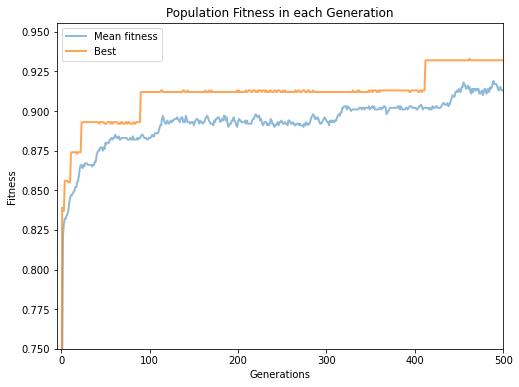

In [108]:
plt.figure(figsize=(8,6),dpi=72)
plt.plot(data['Generation'], data['AvgPopulationFitness'], lw=2, alpha=0.5, label='Mean fitness')
plt.plot(data['Generation'], data['HighestPopulationFitness'], lw=2, alpha=0.7, label='Best')
plt.legend()
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Population Fitness in each Generation')
plt.xlim(-5,500)
plt.ylim(0.75)
plt.savefig('Modified GA fitness.jpeg')
plt.show()

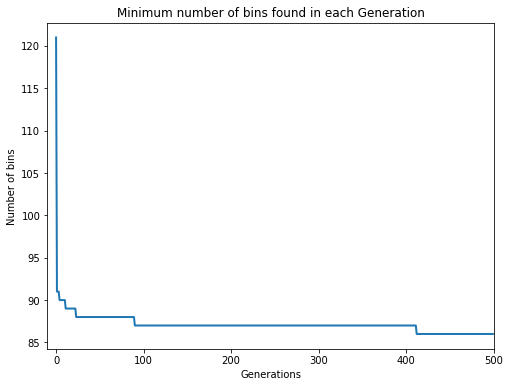

In [109]:
plt.figure(figsize=(8,6),dpi=72)
plt.plot(data['Generation'], data['MinimumBin'], lw=2)
plt.xlabel('Generations')
plt.ylabel('Number of bins')
plt.xlim(-10,500)
plt.title('Minimum number of bins found in each Generation')
plt.savefig('Modified GA bin number.jpeg')
plt.show()

# Statistical Testing

In [199]:
df_simpleGA = pd.read_csv('CollectedDataSGA.csv')
df_modifiedGA = pd.read_csv('CollectedDataMGA.csv')
df_sa = pd.read_csv('CollectedDataSA.csv')
df_hc = pd.read_csv('CollectedDataHC.csv')

In [200]:
print('Average runtime - simple GA:', round(df_simpleGA['Runtime'].mean(),2))
print('Average runtime - modified GA:', round(df_modifiedGA['Runtime'].mean(),2))
print('Average runtime - Simulated Annealing:', round(df_sa['Runtime'].mean(),2))
print('Average runtime - Hill Climber:', round(df_hc['Runtime'].mean(),2))

Average runtime - simple GA: 17.74
Average runtime - modified GA: 23.39
Average runtime - Simulated Annealing: 20.19
Average runtime - Hill Climber: 0.28


In [202]:
print('Minimum number of bins - simple GA:', min(df_simpleGA['MinimumBin']))
print('Minimum number of bins - modified GA:', min(df_modifiedGA['MinimumBin']))
print('Minimum number of bins - Simulated Annealing:', min(df_sa['MinimumBin']))
print('Minimum number of bins - Hill Climber:', min(df_hc['MinimumBin']))

Minimum number of bins - simple GA: 90
Minimum number of bins - modified GA: 87
Minimum number of bins - Simulated Annealing: 90
Minimum number of bins - Hill Climber: 91


In [212]:
print('Mean of the AveragePopulationFitness - simple GA', round(df_simpleGA['AveragePopulationFitness'].mean(),3))
print('Mean of the AveragePopulationFitness - modified GA', round(df_modifiedGA['AveragePopulationFitness'].mean(),3))

Mean of the AveragePopulationFitness - simple GA 0.85
Mean of the AveragePopulationFitness - modified GA 0.901


Performing a t-test to test if there is significant difference between the average population’s fitness achieved by simple GA and modified GA

In [220]:
sga_min_bin = df_simpleGA['AveragePopulationFitness']
mga_min_bin = df_modifiedGA['AveragePopulationFitness']

t_stat, p_value = stats.ttest_ind(sga_min_bin, mga_min_bin)
print(p_value)

alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis; There is a significant difference between the average population’s fitness achieved by simple GA and modified GA')
else:
    print('Fail to reject the null hypothesis; There is no significant difference between the average population’s fitness achieved by simple GA and modified GA' )

9.9672103158642e-12
Reject the null hypothesis; There is a significant difference between the average population’s fitness achieved by simple GA and modified GA


Performing a t-test to test if there is a significant difference between the average runtime of SA and modified GA

In [226]:
sa_runtime = df_sa['Runtime']
mga_runtime = df_modifiedGA['Runtime']

t_stat, p_value = stats.ttest_ind(mga_runtime, sa_runtime)
print(p_value)
alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis; There is a significant difference between the average runtime of SA and modified GA.')
else:
    print('Fail to reject the null hypothesis; There is no significant difference between the average runtime of SA and modified GA.' )

4.819111781324353e-20
Reject the null hypothesis; There is a significant difference between the average runtime of SA and modified GA.
